<a href="https://colab.research.google.com/github/Muzsek/MNIST/blob/main/MNIST_AIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn

In [2]:
transform = transforms.ToTensor()

In [3]:
train_dataset = datasets.MNIST(root='./data', train = True, download = True, transform = transform)
test_dataset = datasets.MNIST(root='./data', train = False, download = True, transform = transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.52MB/s]


In [4]:
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
Label: 6


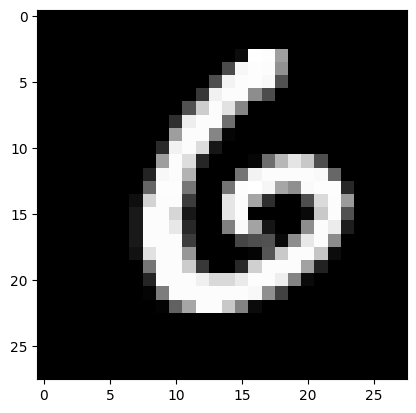

In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.shape}")
print(f"Labels batch shape: {train_labels.shape}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show
print(f"Label: {label}")

In [6]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [29]:
class CNN(nn.Module):
  def __init__(self):
      super().__init__()
      self.conv1_block = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels =32, kernel_size = 3, stride = 1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 1, stride = 2)
      )
      self.conv2_block = nn.Sequential(
          nn.Conv2d(in_channels = 32, out_channels =16, kernel_size = 3, stride = 1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2, stride = 2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=16*5*5,
          out_features=10)
    )
  def forward(self, x):
      x = self.conv1_block(x)
      #print(x.shape)
      x = self.conv2_block(x)
      #print(x.shape)
      x = self.classifier(x)
      #print(x.shape)
      return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
model_0 = CNN().to(device)
model_0

CNN(
  (conv1_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2_block): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=10, bias=True)
  )
)

In [31]:

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.001)



In [32]:
torch.manual_seed(42)

epochs = 10
train_loss = 0
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n----------")
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 400 == 0:
          print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
          print(f"Loss: {loss}")

        train_loss /= len(train_dataloader)

        test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model_0(X)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n Accuracy:{test_acc:.2f}")

Epoch: 0
----------
Looked at 0/60000 samples
Loss: 2.330192804336548
Looked at 25600/60000 samples
Loss: 0.24269622564315796
Looked at 51200/60000 samples
Loss: 0.05164086073637009

Train loss: 0.00020 | Test loss: 0.10040, Test acc: 96.95%
 Accuracy:96.95
Epoch: 1
----------
Looked at 0/60000 samples
Loss: 0.11316309869289398
Looked at 25600/60000 samples
Loss: 0.025378450751304626
Looked at 51200/60000 samples
Loss: 0.03198694437742233

Train loss: 0.00004 | Test loss: 0.06345, Test acc: 98.14%
 Accuracy:98.14
Epoch: 2
----------
Looked at 0/60000 samples
Loss: 0.0685749277472496
Looked at 25600/60000 samples
Loss: 0.044943131506443024
Looked at 51200/60000 samples
Loss: 0.07892325520515442

Train loss: 0.00009 | Test loss: 0.06126, Test acc: 97.99%
 Accuracy:97.99
Epoch: 3
----------
Looked at 0/60000 samples
Loss: 0.03534361347556114
Looked at 25600/60000 samples
Loss: 0.02150440588593483
Looked at 51200/60000 samples
Loss: 0.038910187780857086

Train loss: 0.00003 | Test loss: 0.

KeyboardInterrupt: 